In [1]:
%pip install -q lightning pyarrow einops vit_pytorch torchdata python-box timm geoarrow-pyarrow

Note: you may need to restart the kernel to use updated packages.


In [1]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


In [2]:
from datetime import datetime
import math
from datetime import datetime

from rastervision.pipeline.file_system.utils import json_to_file, file_to_json
from rastervision.core import Box, RasterStats
from rastervision.core.data import (
    RasterioCRSTransformer, Scene, StatsTransformer, XarraySource)
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.aws_s3 import S3FileSystem
from rastervision.pytorch_learner import (
    SemanticSegmentationSlidingWindowGeoDataset)

import yaml
from box import Box as PyBox
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader
import pystac_client
import stackstac
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

# Load model

In [3]:
from torch import nn
import torchvision
from torchvision.models import resnet18
from torchvision.transforms import v2
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [4]:
BANDS = [
    # 'coastal', # B01
    'blue', # B02
    'green', # B03
    'red', # B04
    # 'rededge1', # B05
    # 'rededge2', # B06
    # 'rededge3', # B07
    'nir', # B08
    # 'nir08', # B8A
    # 'nir09', # B09
    # 'swir16', # ???
    # 'swir16', # B11
    # 'swir22', # B12
]

### Clay v1 model

https://huggingface.co/made-with-clay/Clay/

In [5]:
# !mkdir data/clay
# !git clone git@github.com:Clay-foundation/model.git data/clay

In [6]:
# !mkdir data/clay/stacchip
# !git clone git@github.com:Clay-foundation/stacchip.git data/clay/stacchip

In [7]:
class ClayWrapper(nn.Module):
    def __init__(self, model, metadata_path, platform, gsd):
        super().__init__()
        import sys
        sys.path.append('data/clay/stacchip/')
        from stacchip.processors.prechip import normalize_timestamp
        
        self.model = model
        self.normalize_timestamp = normalize_timestamp
        self.platform = platform
        self.gsd = torch.tensor(gsd)

        self.metadata = yaml.safe_load(open(metadata_path))
        band_metadata = self.metadata[self.platform]['bands']
        self.waves = torch.tensor([band_metadata['wavelength'][b] for b in BANDS])

        mean = [band_metadata['mean'][b] for b in BANDS]
        std = [band_metadata['std'][b] for b in BANDS]        
        self.transform = v2.Compose([
            v2.Normalize(mean=mean, std=std),
        ])

    def forward(self, x: torch.Tensor, times: list[str], latlons: list[tuple[float, float]]) -> torch.Tensor:
        x = self.transform(x)
        device = x.device

        latlons = [self.normalize_latlon(lat, lon) for lat, lon in latlons]
        lat_norm = [lat for lat, _ in latlons]
        lon_norm = [lon for _, lon in latlons]
        latlon_inp = torch.tensor(
            np.hstack((lat_norm, lon_norm)), 
            dtype=torch.float32, 
            device=device,
        )
        
        times = [self.normalize_timestamp(t) for t in times]
        week_norm = [week for week, _ in times]
        hour_norm = [hour for _, hour in times]
        time_inp = torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        )

        datacube = dict(
            platform=self.platform,
            time=time_inp,
            latlon=latlon_inp,
            pixels=x.to(device),
            gsd=self.gsd,
            waves=self.waves,
        )

        out, _, _, _ = self.model.encoder(datacube)
        # The first embedding is the class token, which is the
        # overall single embedding.
        out = out[:, 0, :]
        return out

    def normalize_latlon(self, lat, lon):
        lat = lat * np.pi / 180
        lon = lon * np.pi / 180
        return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def get_clay_model(ckpt, metadata_path):
    import sys
    sys.path.append('data/clay/model/')
    from src.model import ClayMAEModule
    model = ClayMAEModule.load_from_checkpoint(
        ckpt,
        metadata_path=metadata_path,
        mask_ratio=0,
        shuffle=False,
    )
    model = model.model
    model = model.to(device=DEVICE)
    model = model.eval()

    model = ClayWrapper(model, metadata_path, platform='sentinel-2-l2a', gsd=10)

    return model

In [8]:
ckpt = 'https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt'
metadata_path = 'data/clay/model/configs/metadata.yaml'

In [9]:
model = get_clay_model(ckpt, metadata_path)

---

## Find images

In [10]:
bbox = Box(xmin=67.882, ymin=27.674, xmax=67.929, ymax=27.825)
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=27.674, xmin=67.882, ymax=27.825, xmax=67.929)

In [11]:
URL = 'https://earth-search.aws.element84.com/v1'
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=['sentinel-2-l2a'],
    datetime='2017-01-01/2024-04-30',
    query={'eo:cloud_cover': {'lt': 5}},
).item_collection()
len(items)

621

In [12]:
items = items[::-1]

In [13]:
gdf = gpd.GeoDataFrame.from_features(items)

### Convert to a Raster Vision `RasterSource`

In [14]:
timestamps = [
    datetime.fromisoformat(item.properties['datetime']) for item in items]
timestamps = np.array(timestamps)

In [15]:
# for item in items:
#     for asset in item.assets.values():
#         asset.href = S3FileSystem.url_to_uri(asset.href)

In [16]:
stackstac_args = dict(assets=BANDS, rescale=False, fill_value=0, dtype='float32')

bbox_pixel = Box(ymin=1000-6, xmin=6000-6, ymax=1500+6, xmax=6500+6)

raster_sources = [
    XarraySource.from_stac(item, bbox=bbox_pixel, allow_streaming=True, stackstac_args=stackstac_args)
    for item in tqdm(items)
]

  0%|          | 0/621 [00:00<?, ?it/s]

In [17]:
dses = [
    SemanticSegmentationSlidingWindowGeoDataset(
        Scene('', rs),
        size=512,
        stride=512,
        out_size=256,
    ) 
    for rs in tqdm(raster_sources)
]

  0%|          | 0/621 [00:00<?, ?it/s]

In [18]:
ds = ConcatDataset(dses)
len(ds)

621

In [19]:
dl = DataLoader(ds, batch_size=4, num_workers=4, shuffle=False, pin_memory=True)

---

## Generate embeddings

### Run inference

In [20]:
c = bbox.to_shapely().centroid
lon, lat = c.x, c.y
lon, lat

(67.9055, 27.749499999999998)

In [ ]:
emb_dims = 768
embeddings = torch.zeros(len(timestamps), emb_dims)

i = 0
with torch.inference_mode(), tqdm(dl, desc='Creating embeddings') as bar:
    for x, _ in bar:
        ts = timestamps[i: i + len(x)]
        latlons = [(lat, lon)] * len(x)
        x = x.to(DEVICE)
        emb = model(x, ts, latlons).squeeze()
        embeddings[i:i + len(x)] = emb.cpu()
        i += len(x)

In [168]:
window_geom = raster_sources[0].bbox.to_shapely()
window_geom_map = raster_sources[0].crs_transformer.pixel_to_map(window_geom)
good_dates_mask = np.array([window_geom_map.within(g) for g in gdf.geometry])
print('# bad', (~good_dates_mask).sum())

# bad 296


In [171]:
embeddings = embeddings[good_dates_mask]
timestamps = timestamps[good_dates_mask]
len(embeddings)

325

In [172]:
embeddings_info = dict(
    embeddings=embeddings, 
    timestamps=timestamps, 
    dates=np.array([str(t.date()) for t in timestamps]), 
)
torch.save(embeddings_info, 'data/embeddings_clayv1_rgbnir_chip512.pt')

## Analysis

In [4]:
embeddings_info = torch.load('data/embeddings_clayv1_rgbnir_chip512.pt')
embeddings = embeddings_info['embeddings']
dates = embeddings_info['dates']
embeddings.shape

torch.Size([325, 768])

In [5]:
# N = len(embeddings)
# embeddings = embeddings[np.arange(N) != error.argmax()]
# dates = dates[np.arange(N) != error.argmax()]

In [6]:
embeddings -= embeddings.mean(axis=0)

In [7]:
dates_flood = np.array([
    '2020-07-15', '2020-09-08', '2020-09-18', '2020-09-23',
    '2020-09-28', '2020-10-03', '2020-10-08', '2020-10-18',
    '2020-10-28', '2022-09-03', '2022-09-08', '2022-09-13',
    '2022-09-23', '2022-09-28', '2022-10-03', '2022-10-08',
    '2022-10-13', '2022-10-18', '2022-10-23', '2022-10-28'
])

In [8]:
t_doy = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates])
t_doy_flood = np.array([datetime.strptime(date, '%Y-%m-%d').timetuple().tm_yday for date in dates_flood])

t_foy = np.clip(t_doy / 365, 0, 1)

In [9]:
def to_t_day(date):
    timetuple = datetime.strptime(date, '%Y-%m-%d').timetuple()
    year = timetuple.tm_year
    doy = np.clip(timetuple.tm_yday / 365, 0, 1)
    return year + doy

In [10]:
t_day = np.array([to_t_day(date) for date in dates])
t_day_flood = np.array([to_t_day(date) for date in dates_flood])

---

### PCA

In [11]:
train_mask = np.array([date < '2023-07-01' for date in dates])

In [15]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True)
# pca.fit(embeddings[train_mask])
pca.fit(embeddings)
pca_emb = pca.transform(embeddings)
pca_emb.shape

(325, 325)

### Regression

In [16]:
from sklearn.linear_model import RANSACRegressor
from matplotlib.colors import Normalize

def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

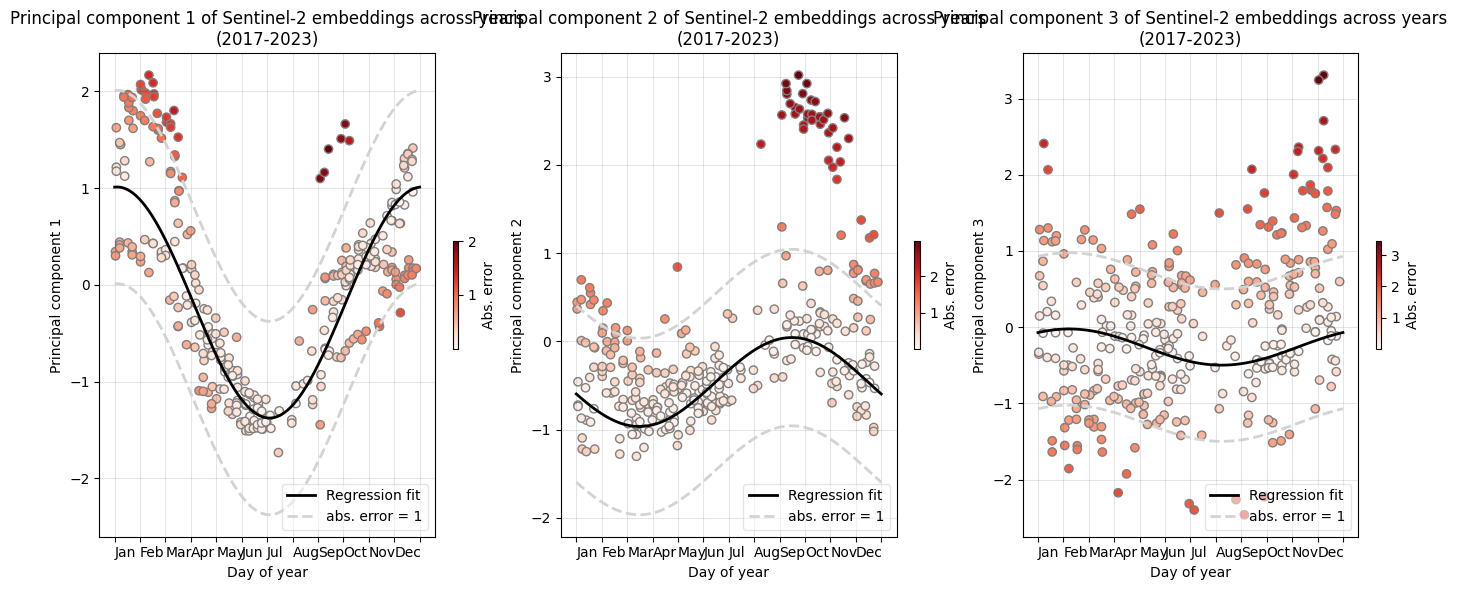

In [17]:
plt.close('all')
fig, axs = plt.subplots(1, 3, figsize=(14, 6), squeeze=True, tight_layout=True)
cmap = plt.get_cmap('Reds')

for pc, ax in enumerate(axs.flat):
    lr = RANSACRegressor()
    Y = pca_emb[:, pc]
    X = t_to_feats(t_foy)
    _ = lr.fit(X, Y)

    x = t_foy
    y_pred = lr.predict(t_to_feats(x))
    error = np.abs(y_pred - pca_emb[:, pc])
    norm = Normalize(error.min(), error.max())
    cols = cmap(norm(error))
    ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

    t = np.linspace(0, 1, 100)
    x = t_to_feats(t)
    y_pred = lr.predict(x)
    ax.plot(t, y_pred, lw=2, c='k', label='Regression fit')
    ax.plot(t, y_pred + 1, lw=2, c='lightgray', ls='--', label='abs. error = 1')
    ax.plot(t, y_pred - 1, lw=2, c='lightgray', ls='--')
    ax.legend(loc='lower left')
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.015, label='Abs. error')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [181]:
pc = 0
lr = RANSACRegressor()
Y = pca_emb[:, pc]
X = t_to_feats(t_foy)
_ = lr.fit(X, Y)

x = t_foy
y_pred = lr.predict(t_to_feats(x))
error = np.abs(y_pred - pca_emb[:, pc])

dates_flood = dates[(t_foy > 0.5) & (error > 1.)]
dates_flood

array(['2020-11-12', '2020-12-02', '2020-12-02', '2020-12-07',
       '2020-12-12', '2020-12-12', '2020-12-17', '2020-12-17',
       '2020-12-22', '2020-12-22', '2022-11-12', '2022-11-22',
       '2022-12-07', '2022-12-17', '2022-12-22', '2022-12-27',
       '2023-09-03', '2023-09-08', '2023-09-13', '2023-09-28',
       '2023-10-03', '2023-10-08'], dtype='<U10')

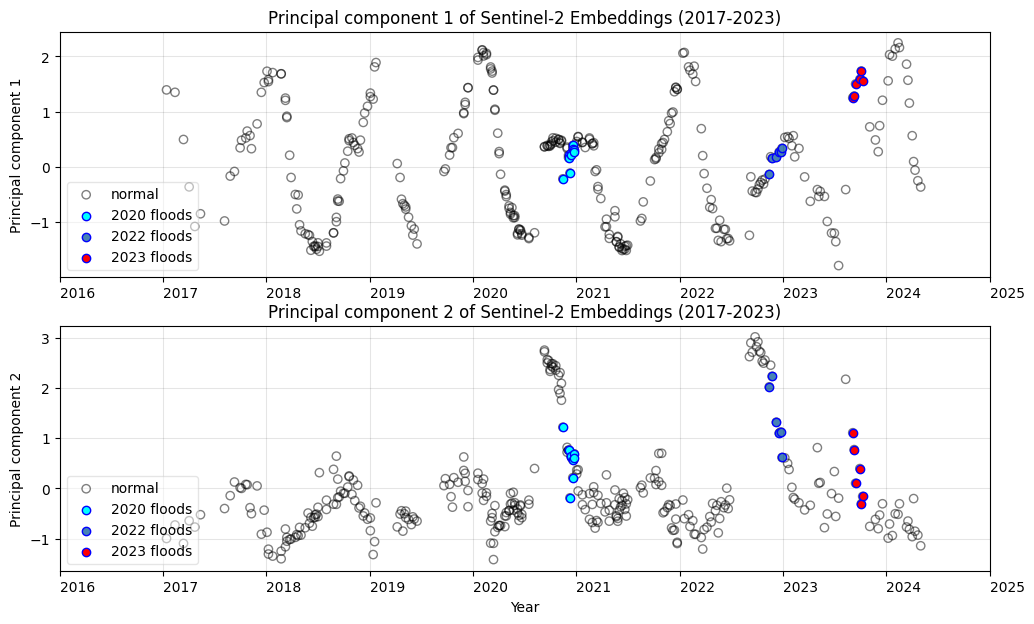

In [213]:
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(12, 7), squeeze=True)

for pc, ax in enumerate(axs):
    ax.scatter(t_day, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_inds_2020 = np.where([date in flood_dates_2020 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2020], pca_emb[flood_inds_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_inds_2022 = np.where([date in flood_dates_2022 for date in dates])[0]
    ax.scatter(t_day[flood_inds_2022], pca_emb[flood_inds_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_day[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower left', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 Embeddings (2017-2023)')
    ax.set_xlim((2016, 2025))
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_ylabel(f'Principal component {pc + 1}')
    if pc == len(axs) - 1:
        ax.set_xlabel('Year')

plt.show()

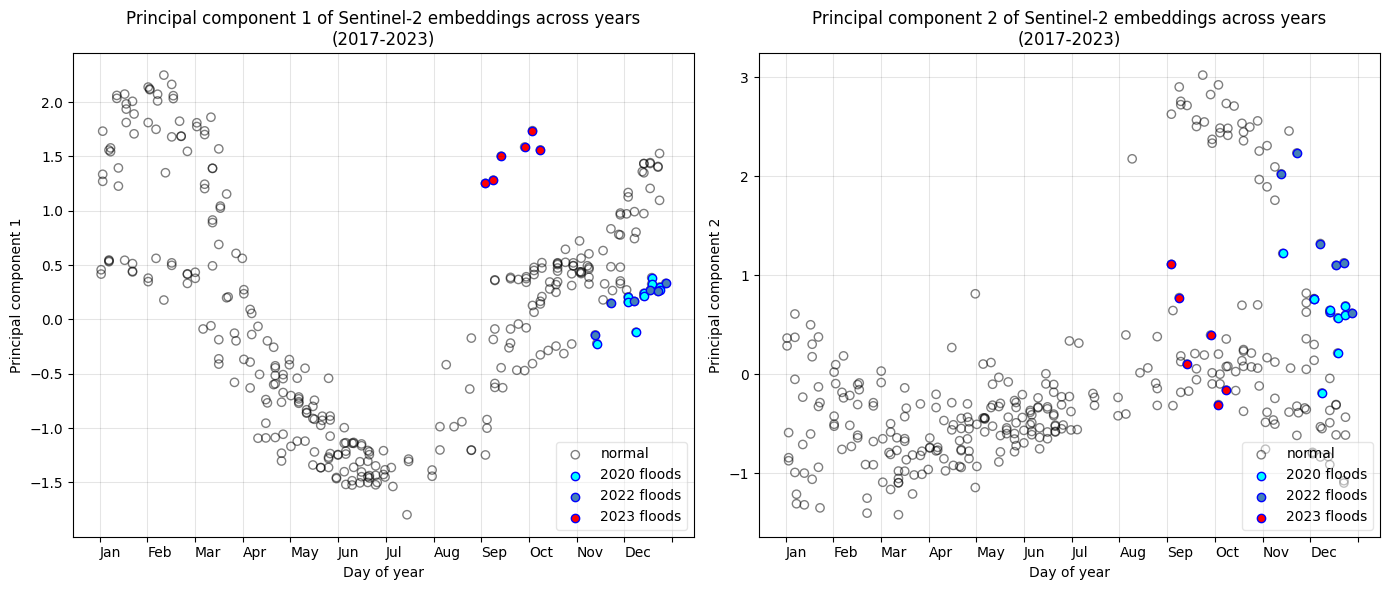

In [214]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(14, 6), squeeze=True, tight_layout=True)

for pc, ax in enumerate(axs.flat):
    ax.scatter(t_foy, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal')
    
    flood_dates_2020 = set([date for date in dates_flood if date.startswith('2020')])
    flood_mask_2020 = np.array([date in flood_dates_2020 for date in dates])
    ax.scatter(t_foy[flood_mask_2020], pca_emb[flood_mask_2020, pc], ec='b', fc='cyan', label='2020 floods')
    
    flood_dates_2022 = set([date for date in dates_flood if date.startswith('2022')])
    flood_mask_2022 = np.array([date in flood_dates_2022 for date in dates])
    ax.scatter(t_foy[flood_mask_2022], pca_emb[flood_mask_2022, pc], ec='b', fc='steelblue', label='2022 floods')
    
    flood_dates_2023 = set([date for date in dates_flood if date.startswith('2023')])
    flood_mask_2023 = np.array([date in flood_dates_2023 for date in dates])
    ax.scatter(t_foy[flood_mask_2023], pca_emb[flood_mask_2023, pc], ec='b', fc='red', label='2023 floods')
    
    ax.legend(loc='lower right', framealpha=0.5)
    ax.grid('--', c='k', alpha=0.1)
    ax.set_xticks(np.arange(0, 13) / 12, 
                  ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('left')
    ax.set_title(f'Principal component {pc + 1} of Sentinel-2 embeddings across years\n(2017-2023)')
    ax.set_xlabel('Day of year')
    ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [198]:
raster_sources_good = np.array(raster_sources)[good_dates_mask]

  0%|          | 0/22 [00:00<?, ?it/s]

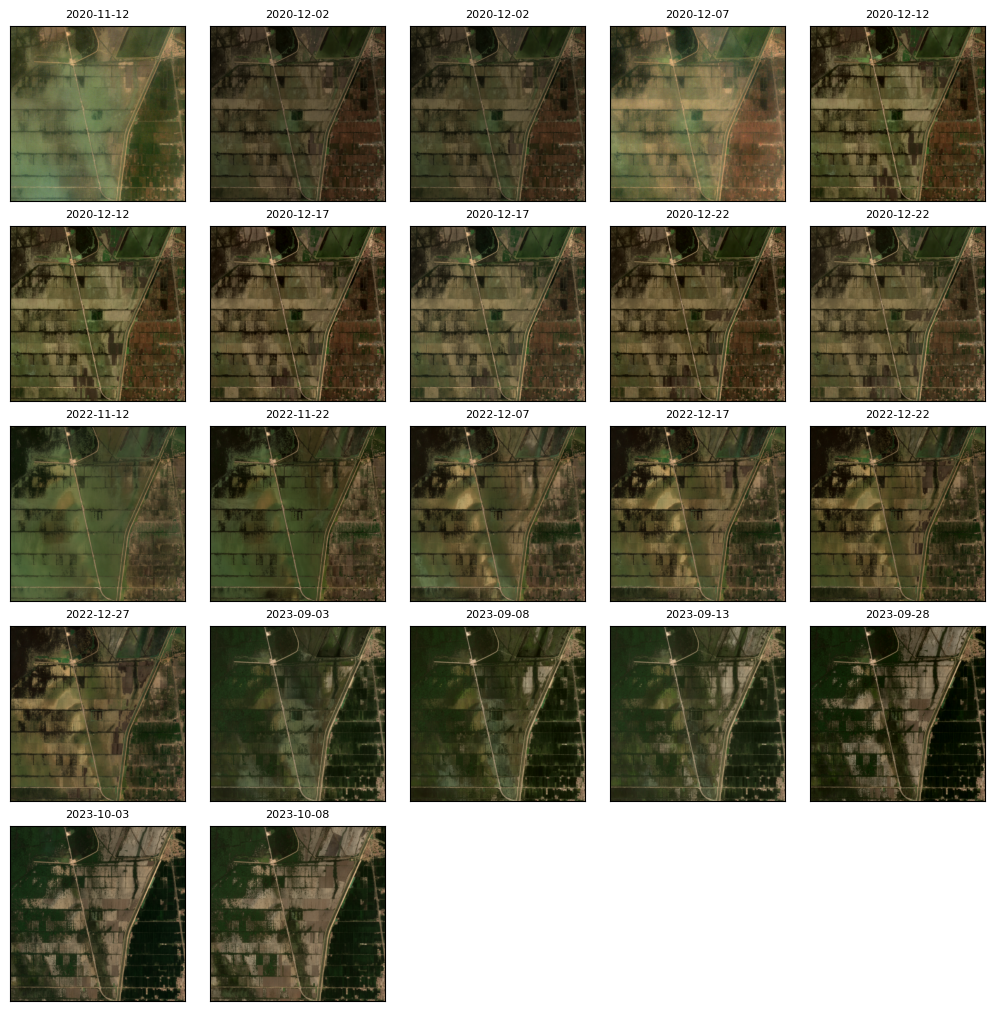

In [199]:
plt.close('all')

ncols = 5
nrows = int(math.ceil(len(dates_flood) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)

# dates_data_array = np.array([str(t.date()) for t in raster_source.data_array.time.to_series()])
ts = np.where([date in dates_flood for date in dates])[0]

with tqdm(zip(ts, dates_flood, axs.flat), total=len(ts)) as bar:
    for i, (t, date, ax) in enumerate(bar):
        chip_t = raster_sources_good[t][..., [2, 1, 0]]
        chip_t = (chip_t - chip_t.min()) / (chip_t.max() - chip_t.min())
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(date, fontsize=8)
if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()

In [ ]:
for i in np.where(good_dates_mask)[0]:
    chip = raster_sources[i][..., [2, 1, 0]]
    chip = (chip - chip.min()) / (chip.max() - chip.min())
    plt.imshow(chip)
    plt.axis('off')
    plt.show()
    if i > 20:
        break